# Лабораторна робота 3: Знайомство з нейромережами

**Виконав:** Бондар Петро

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Завдання 1: Повнозв'язані нейронні мережі

### Вибір та завантаження датасету
Для виконання цієї лабораторної роботи було обрано датасет з лабораторної роботи 1 (оцінка рівнів ожиріння в людей з Мексико, Перу та Колумбії віком від 14 до 61).

Посилання на датасет: https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster

Виконаємо стандартну обробку датасету.

In [2]:
df_obesity = pd.read_csv('data/ObesityDataSet.csv')
df_obesity = df_obesity.rename(columns={'family_history_with_overweight': 'FAM_OVERWEIGHT', 'NObeyesdad': 'Obesity_level'})
TARGET_VAR = 'Obesity_level'
OTHER_FEATURES = df_obesity.columns.drop(['Obesity_level'])

df_obesity['MTRANS'] = df_obesity['MTRANS'].map({'Walking'               : 0.0, 
                                                 'Bike'                  : 0.15, 
                                                 'Public_Transportation' : 0.5, 
                                                 'Motorbike'             : 0.75, 
                                                 'Automobile'            : 1.0})

FREQ_CATEG_to_NUM = {'Always' : 1.0, 'Frequently' : 0.66, 'Sometimes' : 0.33, 'no' : 0.0}
BIN_CATEG_to_NUM = {'yes' : 1.0, 'no' : 0.0}

df_obesity['CAEC'] = df_obesity['CAEC'].map(FREQ_CATEG_to_NUM)
df_obesity['CALC'] = df_obesity['CALC'].map(FREQ_CATEG_to_NUM)

df_obesity['FAM_OVERWEIGHT'] = df_obesity['FAM_OVERWEIGHT'].map(BIN_CATEG_to_NUM)
df_obesity['FAVC'] = df_obesity['FAVC'].map(BIN_CATEG_to_NUM)
df_obesity['SMOKE'] = df_obesity['SMOKE'].map(BIN_CATEG_to_NUM)
df_obesity['SCC'] = df_obesity['SCC'].map(BIN_CATEG_to_NUM)
df_obesity['Gender'] = df_obesity['Gender'].map({'Male': 1.0, 'Female': 0.0})

OBESITY_TRANSFORM_MAP = {'Insufficient_Weight' : 0,
                         'Normal_Weight'       : 1,
                         'Overweight_Level_I'  : 2,
                         'Overweight_Level_II' : 3,
                         'Obesity_Type_I'      : 4,
                         'Obesity_Type_II'     : 5,
                         'Obesity_Type_III'    : 6}

df_obesity['Obesity_level'] = df_obesity['Obesity_level'].map(OBESITY_TRANSFORM_MAP)


In [3]:
df_obesity.shape
df_obesity.head()

,Gender,Age,Height,Weight,FAM_OVERWEIGHT,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity_level
0,0.0,21.0,1.62,64.0,1.0,0.0,2.0,3.0,0.33,0.0,2.0,0.0,0.0,1.0,0.00,0.5,1
1,0.0,21.0,1.52,56.0,1.0,0.0,3.0,3.0,0.33,1.0,3.0,1.0,3.0,0.0,0.33,0.5,1
2,1.0,23.0,1.80,77.0,1.0,0.0,2.0,3.0,0.33,0.0,2.0,0.0,2.0,1.0,0.66,0.5,1
3,1.0,27.0,1.80,87.0,0.0,0.0,3.0,3.0,0.33,0.0,2.0,0.0,2.0,0.0,0.66,0.0,2
4,1.0,22.0,1.78,89.8,0.0,0.0,2.0,1.0,0.33,0.0,2.0,0.0,0.0,0.0,0.33,0.5,3


### Розбиваємо даніна дві групи: навчання нейромережі та для перевірки, а також нормалізуємо дані по статистикам тренувального набору

In [4]:
from sklearn.preprocessing import StandardScaler

X, y = df_obesity.drop(['Obesity_level'], axis=1), df_obesity['Obesity_level']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1688, 16), (1688,), (423, 16), (423,))

In [5]:
counts = np.bincount(y_train)
print(f"Imbalance counts in training sample: {counts}")

Imbalance counts in training sample: [218 230 230 233 283 238 256]


### Створюємо модель для класифікації

Вхід: 17 нейронів (X_train.shape[1:])
Параметрів для тренування: 539 655

Для уникнення оверфіттінгу (не те щоб він на такому наборі даних станеться із високою імовірністю), використовуємо Dropout із імовірністю 30%.

Задля інтересу на одному етапі нормалізації явно відключимо навчання (емпіричним методом я дізнався, що це покращило загальний рахунок :D).

In [7]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=X_train.shape[1:]),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(trainable=True),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(trainable=False),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(7, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,703 (2.07 MB)

 Trainable params: 538,631 (2.05 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [8]:
model.compile(loss='sparse_categorical_crossentropy',   optimizer='adam', metrics=['accuracy'])

In [9]:
y_train.shape

(1688,)

In [10]:
history = model.fit(X_train,
                    y_train,
                    epochs=12,
                    batch_size=40,                                   
                    validation_data=(X_val, y_val))

Epoch 1/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5292 - loss: 1.3281 - val_accuracy: 0.7872 - val_loss: 1.1901
Epoch 2/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8056 - loss: 0.5159 - val_accuracy: 0.8227 - val_loss: 0.8775
Epoch 3/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8446 - loss: 0.4316 - val_accuracy: 0.8416 - val_loss: 0.6900
Epoch 4/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.2637 - val_accuracy: 0.8700 - val_loss: 0.4916
Epoch 5/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8903 - loss: 0.2767 - val_accuracy: 0.9125 - val_loss: 0.3810
Epoch 6/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9193 - loss: 0.2123 - val_accuracy: 0.8865 - val_loss: 0.3191
Epoch 7/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9107 - loss: 0.2394 - val_accuracy: 0.8889 - val_loss: 0.3140
Epoch 8/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9199 - loss: 0.2343 - val_accuracy: 0.8960 - val_loss:

### Отримуємо результати навчання та тестуємо отриманий результат

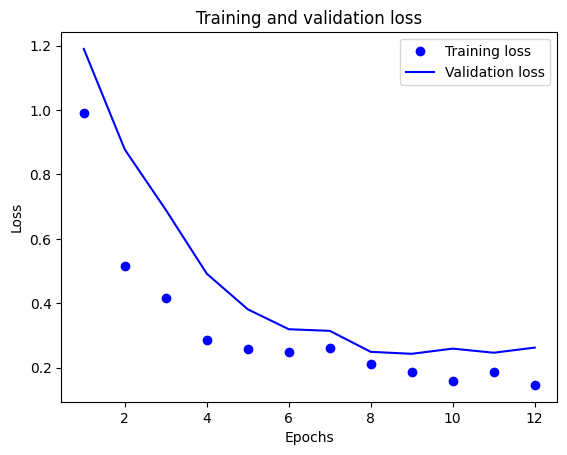

In [11]:
history_dict = history.history
history_dict.keys()

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
score = model.evaluate(X_val, y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.2619984745979309
Test accuracy: 0.9172576665878296
